In [1]:
import os, random
import numpy as np
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
PROCESSED_DIR = "DataSet/processed_data"

def make_pairs(base_dir):
    valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".webp")

    genuine = {}
    forged = []

    for cls in ["genuine", "forged"]:
        cls_dir = os.path.join(base_dir, cls)
        for f in os.listdir(cls_dir):
            if not f.lower().endswith(valid_ext):
                continue   # 🔥 skip non-image files

            path = os.path.join(cls_dir, f)
            writer = f.split("_")[0]

            if cls == "genuine":
                genuine.setdefault(writer, []).append(path)
            else:
                forged.append(path)

    pairs, labels = [], []

    # POSITIVE PAIRS
    for writer, imgs in genuine.items():
        if len(imgs) < 2:
            continue
        for i in range(len(imgs) - 1):
            pairs.append((imgs[i], imgs[i + 1]))
            labels.append(1)

    # NEGATIVE PAIRS
    for writer, imgs in genuine.items():
        for img in imgs:
            neg = random.choice(forged)
            pairs.append((img, neg))
            labels.append(0)

    return pairs, labels



In [2]:
def load_pair(img1, img2, label):

    def _load(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)   # or decode_jpeg if jpg
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)
        return img

    return (_load(img1), _load(img2)), label

def make_tf_dataset(pairs, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((pairs, labels))
    ds = ds.map(lambda p, l: load_pair(p[0], p[1], l),
                num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


In [3]:
def build_embedding():
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    inp = tf.keras.Input((*IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.Model(inp, x)


In [4]:
def contrastive_loss(y, d, margin=1.0):
    y = tf.cast(y, tf.float32)
    return tf.reduce_mean(
        y * tf.square(d) +
        (1 - y) * tf.square(tf.maximum(margin - d, 0))
    )

def build_siamese():
    embed = build_embedding()

    i1 = tf.keras.Input((*IMG_SIZE, 3))
    i2 = tf.keras.Input((*IMG_SIZE, 3))

    e1 = embed(i1)
    e2 = embed(i2)

    dist = tf.keras.layers.Lambda(
        lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True))
    )([e1, e2])

    model = tf.keras.Model([i1, i2], dist)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=contrastive_loss
    )
    return model



In [5]:
train_pairs, train_labels = make_pairs(os.path.join(PROCESSED_DIR, "train"))
val_pairs, val_labels     = make_pairs(os.path.join(PROCESSED_DIR, "val"))

train_ds = make_tf_dataset(train_pairs, train_labels)
val_ds   = make_tf_dataset(val_pairs, val_labels, shuffle=False)

siamese_model = build_siamese()

siamese_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)



Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 630ms/step - loss: 41.2107 - val_loss: 0.0000e+00
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - loss: 38.3877 - val_loss: 0.0000e+00
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 35.9101 - val_loss: 0.0000e+00
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - loss: 33.4334 - val_loss: 0.0000e+00
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 31.6811 - val_loss: 0.0000e+00
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - loss: 29.5275 - val_loss: 0.0000e+00


In [9]:
import matplotlib.pyplot as plt

def verify_signature_with_display(img1, img2, model, threshold=0.8):
    def load(p):
        img = tf.keras.utils.load_img(p, target_size=IMG_SIZE)
        arr = tf.keras.utils.img_to_array(img)
        return img, np.expand_dims(arr, 0)

    i1, a1 = load(img1)
    i2, a2 = load(img2)

    dist = float(model.predict([a1, a2], verbose=0)[0][0])
    result = "MATCH (Likely Genuine)" if dist < threshold else "NOT MATCH (Likely Forged)"

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(i1)
    plt.axis("off")
    plt.title("Reference")

    plt.subplot(1,2,2)
    plt.imshow(i2)
    plt.axis("off")
    plt.title("Test")

    plt.suptitle(
        f"{result}\nDistance: {dist:.4f} | Threshold: {threshold}",
        fontsize=12,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    return dist, result


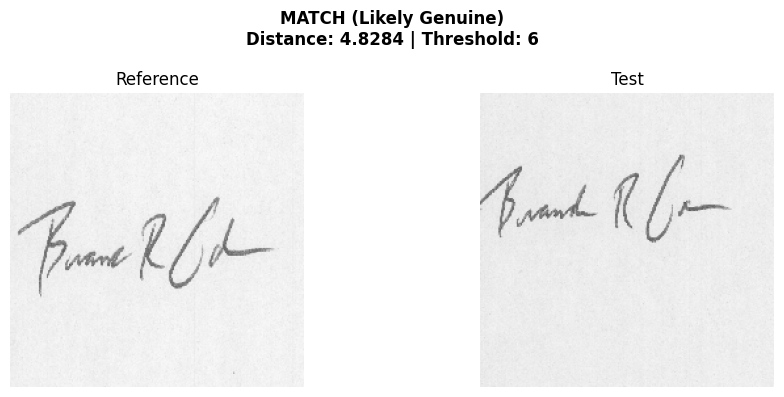

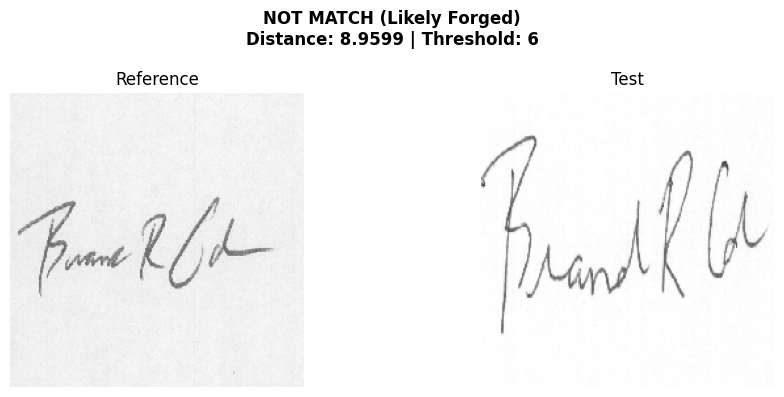

(8.959864616394043, 'NOT MATCH (Likely Forged)')

In [8]:
threshold = 6

verify_signature_with_display(
    r"DataSet\full_org\original_15_2.png",
    r"DataSet\full_org\original_15_3.png",
    siamese_model,
    threshold=threshold
)

verify_signature_with_display(
    r"DataSet\full_org\original_15_2.png",
    r"DataSet\full_forg\forgeries_15_2.png",
    siamese_model,
    threshold=threshold
)
